# Building a ML Feature Backed Agent System To Take Hyper-Personalized Actions

## Objective

1. Extract features from CRM customer responses and platform activities
2. Use a predictive ML to predict churn
3. Delegate to different agents to take actions 

## Assumption

1. CRM has a database that we can query for customer responses and the return can be a dataframe
2. The platform activities are also stored in a database
3. The churn prediction model is deployed and can be called by rest API
4. The action is drafting emails

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import random
random.seed(42)

def generate_responses(user, n, t_range=(0, 40), c_range=(1,20)):
    comments = ["Don't bother me again", "I appreciate your help", "I will think about it"]
    for _ in range(n):
        t = random.uniform(*t_range)
        yield dict(
            ts=datetime(2024, 11, 1) + timedelta(days=t),
            agent_id=user,
            customer_id=random.randint(*c_range),
            email_response=random.choice(comments),
        )

def generate_visits(user, n, t_range=(0, 40), pages = ["front_page", "contacts", "properties_for_sale"]):
    for _ in range(n):
        t = random.uniform(*t_range)
        yield dict(
            ts=datetime(2024, 11, 1) + timedelta(days=t),
            agent_id=user,
            page_id=random.choice(pages),
            visits=1,
        )

## Responses dataset

In [ ]:
df1 = pd.DataFrame(generate_responses("a1", 20, (0,40)))
df2 = pd.DataFrame(generate_responses("a1", 50, (0,30)))
df3 = pd.DataFrame(generate_responses("a2", 20, (0,40)))
df4 = pd.DataFrame(generate_responses("a2", 50, (30,40)))
df = pd.concat([df1, df2, df3, df4])
df["ts"] = pd.to_datetime(df.ts)
responses = df.sort_values(by=["ts"]).reset_index(drop=True)

responses

## Platform activities dataset

In [ ]:
df1 = pd.DataFrame(generate_visits("a1", 50, (0,40), pages = ["front_page"]))
df2 = pd.DataFrame(generate_visits("a1", 200, (0,30)))
df3 = pd.DataFrame(generate_visits("a2", 100, (0,40)))
df4 = pd.DataFrame(generate_visits("a2", 200, (30,40)))
df = pd.concat([df1, df2, df3, df4])
df["ts"] = pd.to_datetime(df.ts)
visits = df.sort_values(by=["ts"]).reset_index(drop=True)

visits

In [ ]:
from tecton import Aggregate
from tecton.types import Field as TectonField, Int64, Float64, String
from tecton_gen_ai.testing import (
    make_local_source,
    set_dev_mode,
    make_local_batch_feature_view,
)

set_dev_mode()

## Agent Info as features

In [ ]:
agent_info_data = [
    {
        "ts": datetime(2024,1,1),
        "agent_id": "a1",
        "name": "Jim",
        "cap": "high",
    },
    {
        "ts": datetime(2024,1,1),
        "agent_id": "a2",
        "name": "Lucy",
        "cap": "low",
    },
]

agent_info = make_local_batch_feature_view(
    "agent_info",
    agent_info_data,
    entity_keys=["agent_id"],
    timestamp_field = "ts",
    description="User profile, including name and cap segment",
)

request = pd.DataFrame([{"agent_id": "a1", "ts": datetime.now()}])
agent_info.get_features_for_events(request).to_pandas()

## Platform activities as features

In [ ]:
platform_activities = make_local_batch_feature_view(
    "platform_activities",
    visits,
    entity_keys=["agent_id"],
    timestamp_field="ts",
    features=[
        Aggregate(
            input_column=TectonField("visits", Int64),
            function="count",
            time_window=timedelta(days=7),
            name="7_days_page_views",
        ),
        Aggregate(
            input_column=TectonField("visits", Int64),
            function="count",
            time_window=timedelta(days=28),
            name="28_days_page_views",
        ),
    ],
    description="Platform activities",
    aggregation_interval=timedelta(hours=4),
    max_rows = 2000,
)

request = pd.DataFrame([{"agent_id": "a2", "ts": datetime.now()}])
platform_activities.get_features_for_events(request).to_pandas()

## Using LLM to extract email sentiment as features

In [ ]:
from pydantic import BaseModel, Field
from tecton import Entity
from tecton_gen_ai.api import llm_extraction

class Sentiment(BaseModel):
    sentiment_score: float = Field(
        description="sentiment score of the email response, from 0 (most negative) to 1 (most positive)"
    )


src = make_local_source(
    "src",
    responses,
    timestamp_field="ts",
    max_rows=200,
)

agent_id = Entity(
    name="agent_id",
    join_keys=[TectonField(name="agent_id", dtype=String)],
    description="Keller Williams agent id, starting with letter `a`",
)

customer_activities = llm_extraction(
    src,
    name="customer_activities",
    #aggregation_secondary_key="customer_id",
    extraction_config=[
        {
            "model": "openai/gpt-4o-mini",
            "column": "email_response",
            "schema": Sentiment,
        },
    ],
    features=[
        Aggregate(
            input_column=TectonField("sentiment_score", Float64),
            function="mean",
            time_window=timedelta(days=7),
            name="7_days_sentiment",
        ),
        Aggregate(
            input_column=TectonField("sentiment_score", Float64),
            function="mean",
            time_window=timedelta(days=28),
            name="28_days_sentiment",
        ),
        Aggregate(
            input_column=TectonField("customer_id", Int64),
            function="count",
            time_window=timedelta(days=7),
            name="7_days_responses",
        ),
        Aggregate(
            input_column=TectonField("customer_id", Int64),
            function="count",
            time_window=timedelta(days=28),
            name="28_days_responses",
        ),
    ],
    entities=[agent_id],
    aggregation_interval=timedelta(hours=4),
)

request = pd.DataFrame([{"agent_id": "a1", "ts": datetime.now()}])
customer_activities.get_features_for_events(request).to_pandas()

## Building a churn indicator and an agent using it

In [ ]:
from tecton_gen_ai.api import prompt, tool, Agent
from tecton_gen_ai.testing import print_md

@tool(sources=[customer_activities, platform_activities])
def churn_indicator(agent_id:str, customer_activities_batch, platform_activities) -> dict:
    """
    Based on recent customer activities and platform activities, identify if the agent is going to churn

    Args:

        agent_id: the id of the agent starting with `a`

    Returns:

        A dict of customer activities plus a key `chrun` indicating whether there is such risk
    """
    # This is a mock, you can put a model inference api call here
    churn1 = customer_activities_batch["7_days_responses"]*4 < customer_activities_batch["28_days_responses"]
    churn2 = platform_activities["7_days_page_views"]*4 < platform_activities["28_days_page_views"]
    churn = churn1 & churn2
    features = {**customer_activities_batch, **platform_activities}
    print_md("## Invoke churn indicator")
    print_md(str(features))
    return {**features, "churn":churn}

agent = Agent(
    "app",
    prompt="You help identify agent churn risk and based on that take actions",
    tools=[churn_indicator],
    llm="openai/gpt-4o",
)

agent.invoke("will this agent churn?", context={"agent_id":"a1"})

## Building A Better Agent With Personal Info Enriched Prompts

* Prompt is enriched by feature
* Output is structured

In [ ]:
from pydantic import BaseModel, Field

class Output(BaseModel):
    agent_name: str = Field(description="The name of the agent")
    churn: bool = Field(desciption="Whether this agent will churn")
    
@prompt(sources=[agent_info])
def sys_prompt(agent_id, agent_info):
    return f"You identify the given agent's churn risk. The agent_id is {agent_id}, The agent name: {agent_info['name']}"
    
agent = Agent(
    "app",
    prompt=sys_prompt,
    tools=[churn_indicator],
    output_schema=Output,
    llm={"model": "openai/gpt-4o", "temperature":0},
)

agent.invoke("will this agent churn?", context={"agent_id":"a2"})

## Building a multi-agent system

## The expected workflow

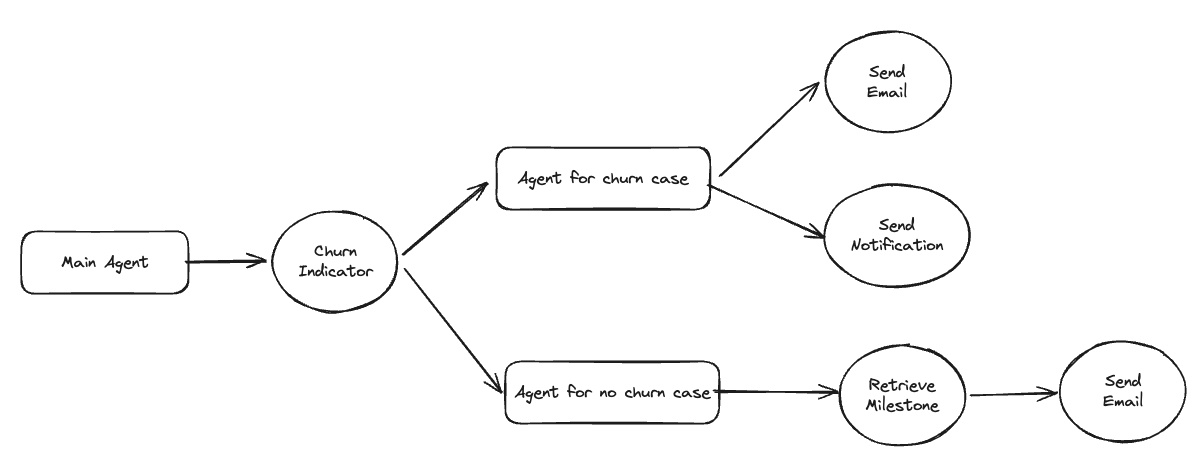

## The fleet structure

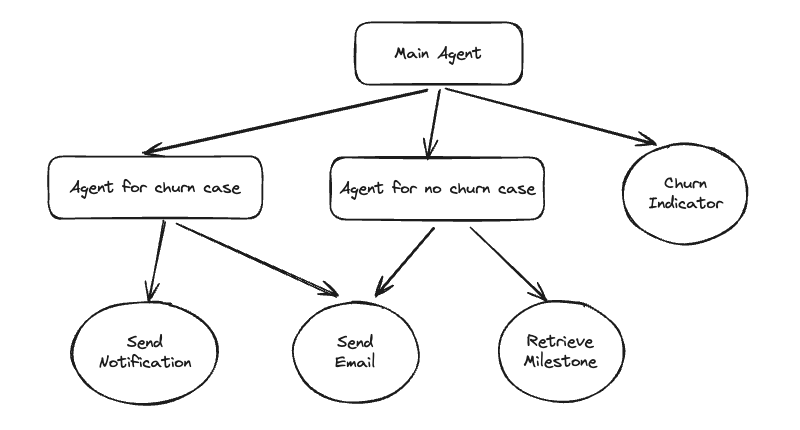

### Tools

In [ ]:
def send_email(agent_id:str, agent_name:str, content:str) -> str:
    """
    Send email to the agent

    Args:

        agent_id: the agent id
        agent_name: the name of the agent
        content: the content of the email
    """
    print_md("## Sending email")
    print_md(agent_id)
    print_md(agent_name)
    print_md(content)
    return "email sent"

def send_notification(agent_id:str, agent_name:str, content:str) -> str:
    """
    Send notification to the agent's report chain

    Args:

        agent_id: the agent id
        agent_name: the name of the agent
        content: the content of the notification
    """
    print_md("## Sending notification")
    print_md(agent_id)
    print_md(agent_name)
    print_md(content)
    return "notification sent"

def get_next_milestone_details(agent_id:str) -> str:
    """
    Get the details of the next milestone for this agent to achieve

    Args:

        agent_id: the agent id

    Returns:

        the details of the milestone
    """
    return "This milestone is getting 100 customers in the next 2 months."

### Agents

In [ ]:
from tecton_gen_ai.api import AgentInputModel

llm={"model": "openai/gpt-4o", "temperature":0}

class SubAgentInput(AgentInputModel):
    agent_id: str = Field(description="the agent id")
    agent_name: str = Field(description="the name of the agent")

churn_agent = Agent(
    "churn_agent",
    input_schema = SubAgentInput,
    description = "Taking action when the agent will churn, the input query should contain the summary of the agent's recent activities",
    prompt = "This agent is going to churn, you need to draft an email to this agent to make him/her stay"
    " and then you need to send a notification to the agent's report chain",
    tools = [send_email, send_notification],
    llm=llm,
)

no_churn_agent = Agent(
    "no_churn_agent",
    input_schema = SubAgentInput,
    description = "Taking action when the agent will not churn, the input query should contain the summary of the agent's recent activities",
    prompt = "You should get the new milestone for this agent and then draft an email to congrat the agent with data points and explain the milestone to achieve",
    tools = [send_email, get_next_milestone_details],
    llm=llm,
)

@prompt(sources=[agent_info])
def sys_prompt(agent_id, agent_info):
    return f"First identify the given agent's churn risk, then take action based on it. The agent_id is {agent_id}, The agent name: {agent_info['name']}"
    
agent = Agent(
    "app",
    prompt=sys_prompt,
    tools=[churn_indicator, churn_agent, no_churn_agent],
    output_schema=Output,
    llm=llm,
)

agent.invoke("", context={"agent_id":"a1"})